In [1]:
import numpy as np
import numpy.ma as ma
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import matplotlib.pyplot as plt

#Import funciton to create line between two points on grid and return list of coordinates
from bresenham import bresenham

In [2]:
#Name of BCG to mask
name = 'A115'

In [3]:
#Open FITS file
hdulist = fits.open('%s.fits' % (name))
hdulist.info()

Filename: A115.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     617   (235, 235)   float32   


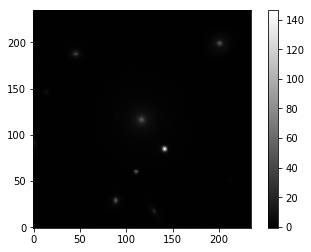

In [4]:
#Plot image. Note: MACSJ1752 and ZwCl0008 are in second header
hdu = hdulist[0]
plt.imshow(hdu.data, cmap = 'gray', origin = 'lower')
plt.colorbar()
plt.show()

In [5]:
#Get the dimensions of the image
data = hdu.data
shape = hdu.shape
shape

(235, 235)

In [6]:
#Create array of zeros to copy the bad pixels to 
mask = np.zeros_like(data)

In [7]:
#searches for maximum value of the array within a certain x and y range
#returns max value and coordinate as tuple
def max_search(array,xmin,xmax,ymin,ymax):
    x_pos = xmin
    y_pos = ymin
    x_max_pos = 0
    y_max_pos = 0
    max = 0.00
    for x_pos in range(xmin, xmax):
        for  y_pos in range(ymin, ymax):
            if max <= array[x_pos,y_pos]:
                max = array[x_pos,y_pos]
                x_max_pos = x_pos
                y_max_pos = y_pos
    print "Max of %f at (%d,%d)\n" % (max, x_max_pos,y_max_pos)  
    return (max,x_max_pos,y_max_pos)
    

In [8]:
#save info about maximum 
max_inf = max_search(data,(shape[0]/2)-(shape[0]/20),(shape[0]/2)+(shape[0]/20),(shape[1]/2)-(shape[1]/20),
                     (shape[1]/2)+(shape[1]/20))

Max of 51.791267 at (116,117)



In [9]:
#Creates initial mask
#Stars by setting the cutoff for brightness as a percentage of max BCG brightness
#Anything above this is considered bad to start
cutoff = 0.05

xmax = max_inf[1]
ymax = max_inf[2]

#Search image to pixels above cutoff
for x in range(0,shape[0]):
    for y in range(0,shape[1]):
        
        #If above cutoff check the pixels in line to the brightest BCG pixel
        if data[x][y] >= (cutoff * max_inf[0]):
            line = list(bresenham(x,y,max_inf[1],max_inf[2]))
            length = len(line)
            i = 0
            
            #Check that pixel brightness increases monotonically towards center
            #If yes, pixel is part of the BCG and is good. If no, pixel is part of other object and bad
            for i in range(0,length - 1):
                if data[line[i+1][0]][line[i+1][1]] < data[line[i][0]][line[i][1]]:
                    mask[x][y] = 1
                    break
                else:
                    mask[x][y] = 0

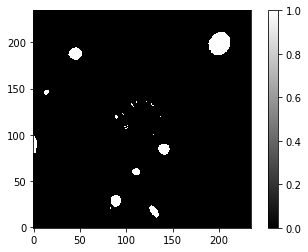

In [10]:
#Replot to see progress
fig = plt.figure()
plt.imshow(mask, cmap = 'gray', origin = 'lower')
plt.colorbar()
plt.show()
fig.savefig('/Users/drakefoote/Documents/Research/Galfit/masks/%s_cutoff.pdf' % (name))

In [11]:
x = 0
y = 0
i = 0

#Need to smooth out fringe pixels that are in very small groups
#Only keep pixel as bad if it has 2 or more neighbors that are also bad. Iterate a few times
for i in range(0,2):
    for x in range(shape[0] / 4,shape[0] - (shape[0] / 4)):
        for y in range(shape[1] / 4,shape[1] - (shape[1] / 4)):
            neighbors = 0
            if mask[x][y] == 1:
                if mask[x+1][y] == 1:
                    neighbors += 1
                if mask[x-1][y] == 1:
                    neighbors += 1
                if mask[x][y+1] == 1:
                    neighbors += 1
                if mask[x][y-1] == 1:
                    neighbors += 1
            if neighbors < 2:
                mask[x][y] = 0
            

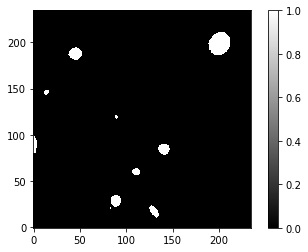

In [12]:
#Replot to see progress
fig = plt.figure()
plt.imshow(mask, cmap = 'gray', origin = 'lower')
plt.colorbar()
plt.show()
fig.savefig('/Users/drakefoote/Documents/Research/Galfit/masks/%s_smooth.pdf' % (name))

In [13]:
#This is necessary to simplify creating the buffer
buff_mask = np.copy(mask)

In [14]:
x = 0
y = 0

#Set buffer radius. Buffer is a square of bad pixels around every previously bad pixel
buffer = 3
for x in range(0,shape[0]):
    for y in range(0,shape[1]):
        if mask[x][y] == 1:
            for i in range(-buffer, buffer + 1):
                for j in range(-buffer, buffer + 1):
                    ii = x + i
                    jj = y + j
                    if ii < 0:
                        ii = 0
                    if ii >= shape[0]:
                        ii = shape[0]-1
                    if jj < 0:
                        jj = 0
                    if jj >= shape[1]:
                        jj = shape[1]-1
                    if buff_mask[ii][jj] != 1:
                        buff_mask[ii][jj] = 1

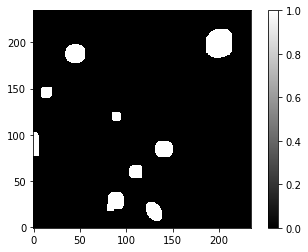

In [15]:
#Plot final mask
fig = plt.figure()
plt.imshow(buff_mask, cmap = 'gray', origin = 'lower')
plt.colorbar()
plt.show()
fig.savefig('/Users/drakefoote/Documents/Research/Galfit/masks/%s_buffer.pdf' % (name))

In [16]:
#Create and save FITS file
hdu_mask = fits.PrimaryHDU(buff_mask)
hdulist_mask = fits.HDUList([hdu_mask])
hdulist_mask.writeto('/Users/drakefoote/Documents/Research/Galfit/fits_files/%s_mask.fits' % (name))

IOError: File '/Users/drakefoote/Documents/Research/Galfit/fits_files/A115_mask.fits' already exists.